In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

import hashlib
from operator import itemgetter

In [2]:
######################################################################
# Sampling rate, related to the Nyquist conditions, which affects
# the range frequencies we can detect.
DEFAULT_FS = 44100

######################################################################
# Size of the FFT window, affects frequency granularity
DEFAULT_WINDOW_SIZE = 4096

######################################################################
# Ratio by which each sequential window overlaps the last and the
# next window. Higher overlap will allow a higher granularity of offset
# matching, but potentially more fingerprints.
DEFAULT_OVERLAP_RATIO = 0.5

######################################################################
# Degree to which a fingerprint can be paired with its neighbors --
# higher will cause more fingerprints, but potentially better accuracy.
DEFAULT_FAN_VALUE = 15

######################################################################
# Minimum amplitude in spectrogram in order to be considered a peak.
# This can be raised to reduce number of fingerprints, but can negatively
# affect accuracy.
DEFAULT_AMP_MIN = 10

######################################################################
# Number of cells around an amplitude peak in the spectrogram in order
# for Dejavu to consider it a spectral peak. Higher values mean less
# fingerprints and faster matching, but can potentially affect accuracy.
PEAK_NEIGHBORHOOD_SIZE = 20

######################################################################
# Thresholds on how close or far fingerprints can be in time in order
# to be paired as a fingerprint. If your max is too low, higher values of
# DEFAULT_FAN_VALUE may not perform as expected.
MIN_HASH_TIME_DELTA = 0
MAX_HASH_TIME_DELTA = 200

######################################################################
# If True, will sort peaks temporally for fingerprinting;
# not sorting will cut down number of fingerprints, but potentially
# affect performance.
PEAK_SORT = True

######################################################################
# Number of bits to throw away from the front of the SHA1 hash in the
# fingerprint calculation. The more you throw away, the less storage, but
# potentially higher collisions and misclassifications when identifying songs.
FINGERPRINT_REDUCTION = 20

In [5]:
import decoder as decoder
import os

In [6]:
#Get current working directory
cwd = os.getcwd()
print(cwd)
filenames = ["\\zero.wav","\\one.wav","\\two.wav","\\three.wav","\\four.wav"]

C:\Users\Minh\Documents\Robotics\Audio\RMRC-vision\Audio


Fingerprinting channel 1/2 for \zero.wav
Finished channel 1/2 for \zero.wav


C:\Users\Minh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7235: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


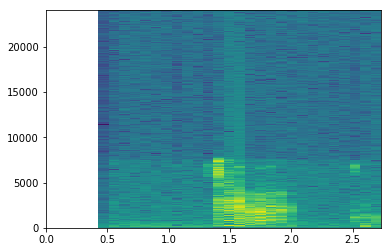

Fingerprinting channel 1/2 for \one.wav
Finished channel 1/2 for \one.wav


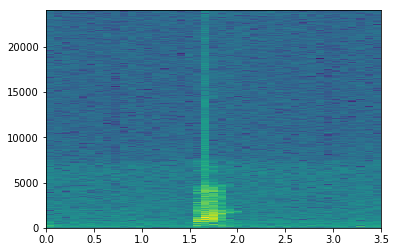

Fingerprinting channel 1/2 for \two.wav
Finished channel 1/2 for \two.wav


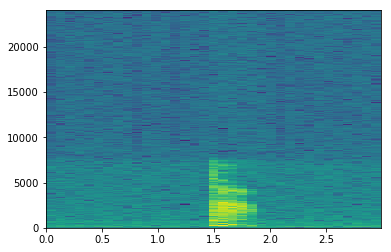

Fingerprinting channel 1/2 for \three.wav
Finished channel 1/2 for \three.wav


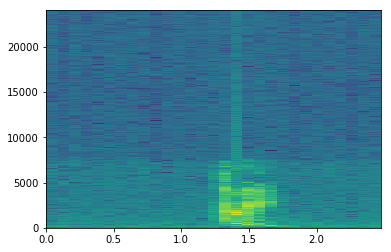

Fingerprinting channel 1/2 for \four.wav
Finished channel 1/2 for \four.wav


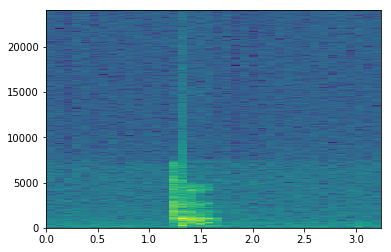

In [7]:
#Fs=DEFAULT_FS,
wsize=DEFAULT_WINDOW_SIZE
wratio=DEFAULT_OVERLAP_RATIO
fan_value=DEFAULT_FAN_VALUE
mp_min=DEFAULT_AMP_MIN

for filename in filenames:


    channels, Fs, file_hash = decoder.read(cwd+filename, 0)
23w
    channel_amount = len(channels)

    print("Fingerprinting channel %d/%d for %s" % (1,
                                                       channel_amount,
                                                       filename))
    plt.specgram(
        channels[0],
        NFFT=wsize,
        Fs=Fs,
        window=mlab.window_hanning,
        noverlap = int(int(wsize) * int(wratio)))[0]

    print("Finished channel %d/%d for %s" % (1, channel_amount,
                                             filename))

    plt.show()
    

In [8]:
from fingerprint import get_2D_peaks,generate_hashes

In [9]:
#Generates fingerprint for 1 audio file
arr2D = mlab.specgram(
        channels[0],
        NFFT=wsize,
        Fs=Fs,
        window=mlab.window_hanning,
        noverlap = int(int(wsize) * int(wratio)))[0]

amp_min = DEFAULT_AMP_MIN

# apply log transform since specgram() returns linear array
arr2D = 10 * np.log10(arr2D)
arr2D[arr2D == -np.inf] = 0  # replace infs with zeros

local_maxima = get_2D_peaks(arr2D, plot=False, amp_min=amp_min)

generate_hashes(local_maxima, fan_value=fan_value)

<generator object generate_hashes at 0x000002B5BA74BAF0>

In [10]:
#Function to generate fingerprint for input audio file
def fingerprint_o(channel, Fs=DEFAULT_FS):
    
    wsize=DEFAULT_WINDOW_SIZE
    wratio=DEFAULT_OVERLAP_RATIO
    fan_value=DEFAULT_FAN_VALUE
    amp_min=DEFAULT_AMP_MIN
    
    arr2D = mlab.specgram(
        channel,
        NFFT=wsize,
        Fs=Fs,
        window=mlab.window_hanning,
        noverlap = int(int(wsize) * int(wratio)))[0]

    # apply log transform since specgram() returns linear array
    arr2D = 10 * np.log10(arr2D)
    arr2D[arr2D == -np.inf] = 0  # replace infs with zeros

    local_maxima = get_2D_peaks(arr2D, plot=False, amp_min=amp_min)

    return generate_hashes(local_maxima, fan_value=fan_value)


#Generate hashes for an audio file
def fingerprint_file(filename, limit=None, song_name=None):
    
    
    song_name, extension = os.path.splitext(os.path.basename(cwd+filename))

    channels, Fs, file_hash = decoder.read(cwd+filename, limit)
    result = set()
    channel_amount = len(channels)  

    print("Fingerprinting channel %d/%d for %s" % (1,
                                                       channel_amount,
                                                       filename))
    hashes = fingerprint_o(channels[0], Fs=Fs)
    print("Finished channel %d/%d for %s" % (11, channel_amount,
                                                 filename))
    result |= set(hashes)

    return song_name, result, file_hash


In [18]:
song_name, result, file_hash = fingerprint_file(filenames[0])
print(song_name)
print(file_hash)
print(type(file_hash))

Fingerprinting channel 1/2 for \zero.wav


C:\Users\Minh\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


Finished channel 11/2 for \zero.wav
zero
12900DDC7BBF588709AB4ACF8C6CA7D6A7142A86
<class 'str'>


In [16]:
name, res, hashes = fingerprint_file("\\Recording.wav")
song_dict={}
song_dict[name] = {
    "song_hash":hashes, "song_result":res
}


'''
sid = self.db.insert_song(song_name, file_hash)

            self.db.insert_hashes(sid, hashes)
            self.db.set_song_fingerprinted(sid)
            self.get_fingerprinted_songs()
'''

Fingerprinting channel 1/2 for \Recording.wav
Finished channel 11/2 for \Recording.wav


'\nsid = self.db.insert_song(song_name, file_hash)\n\n            self.db.insert_hashes(sid, hashes)\n            self.db.set_song_fingerprinted(sid)\n            self.get_fingerprinted_songs()\n'

In [17]:
print(song_dict)

{'Recording': {'song_hash': '4CBE4FE8D5E65420F09C4AF59F690C310B87730D', 'song_result': set()}}
